# Stacking rankers demo

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
import numpy as np
import pandas as pd
from Evaluations import get_evaluation_plots


In [2]:
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1


In [3]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [4]:
test_X = test[columns_to_use]

In [5]:
lgbm_ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [6]:
adaboost_ranker = Ranker(AdaBoostClassifier())

In [7]:
gnb_ranker = Ranker(GaussianNB())

In [8]:
stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], None, use_groups=[True, False, False])

In [9]:
stacker = stacker.fit(train, columns_to_use)

Computing weights...
    Fitting to validation training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.844907
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.150097
[LightGBM] [Debug] init for col-wise cost 0.148226 seconds, init for row-wise cost 0.629772 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.447253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1141
[LightGBM] [Info] Number of data points in the train set: 10319580, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
    Testing on validation set...
Retraining rankers on full training set...
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.844955
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: s

In [10]:
#predicting with rankers, unweighted (all rankers considered equally)
test['unweighted'] = stacker.predict(test_X, weighting=None)

In [11]:
test['MRR_weighted'] = stacker.predict(test_X, weighting="MRR")

In [12]:
test['MAPk_weighted'] = stacker.predict(test_X, weighting="MAPk")

In [13]:
test['Pk_weighted'] = stacker.predict(test_X, weighting="Pk")

ValueError: operands could not be broadcast together with shapes (6658206,) (2,) 

Base rankers already fit to data by stacker, so can just call predict to get their predictions

In [14]:
test['lgbm'] = lgbm_ranker.predict(test_X)

In [15]:
test['adaboost'] = adaboost_ranker.predict(test_X)

In [16]:
test['naive_bayes'] = gnb_ranker.predict(test_X)

In [20]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost', 'naive_bayes']

In [18]:
stacker.ranker_weights

{'MRR': [0.8944874811274849, 0.6906946999336133, 0.8405277140770797],
 'MAPk': [0.8650640535513492, 0.5691033734077476, 0.8024216439666433],
 'Pk': [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0)]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011379344178290979
MAP@12 (only purchasing customers): 0.022631672019209747

MRR (all customers):                0.0021488717699303856
MRR (only purchasing customers):    0.04273757814723835



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.001150056083601461
MAP@12 (only purchasing customers): 0.022872752313283267

MRR (all customers):                0.002168289993331177
MRR (only purchasing customers):    0.043123775151491774



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.001155374424759909
MAP@12 (only purchasing customers): 0.0229785255027557

MRR (all customers):                0.002178514496496539
MRR (only purchasing customers):    0.043327123954878255



Evaluation for lgbm
####################

MAP@12 (all customers):             0.001157985612232424
MAP@12 (only purchasing customers): 0.02303045779123624



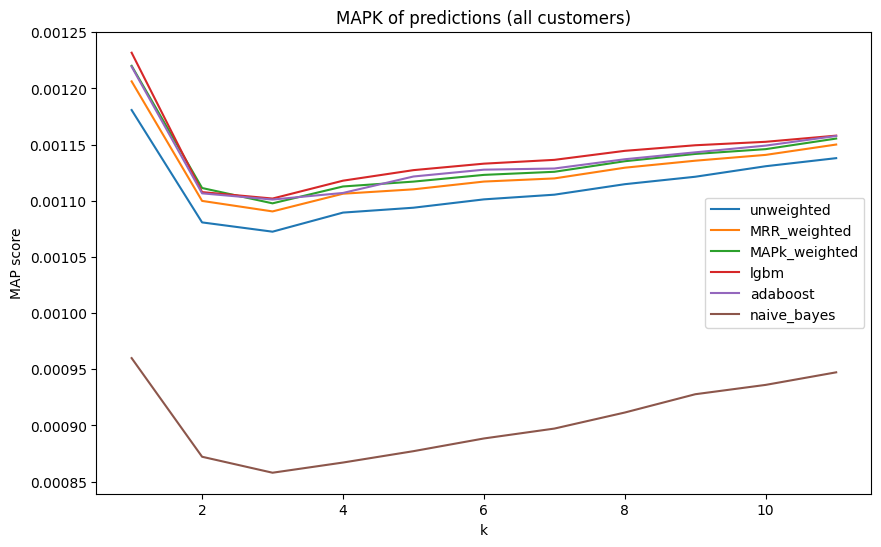

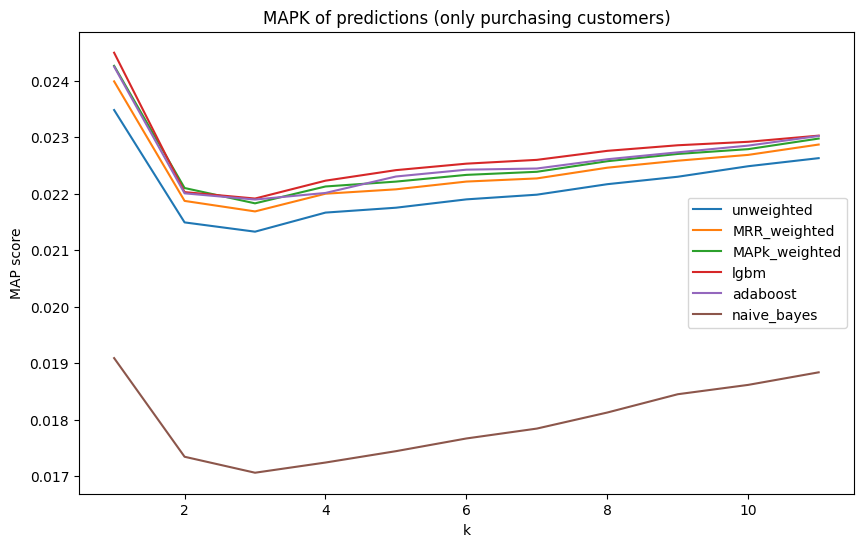

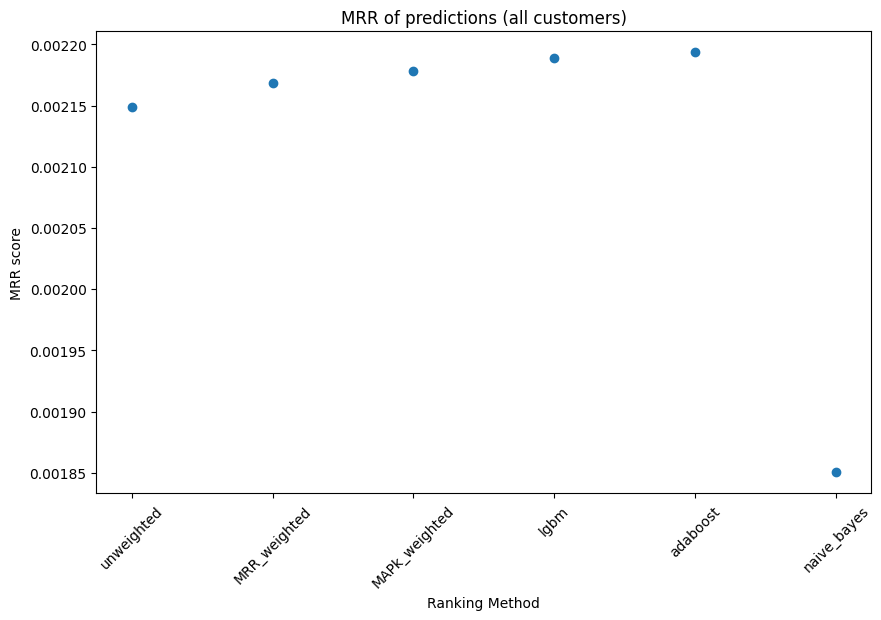

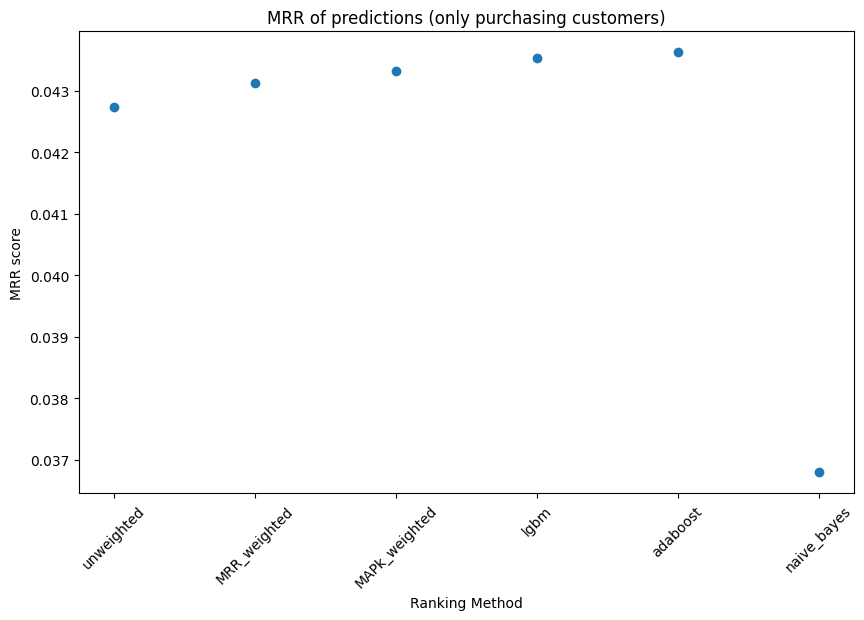

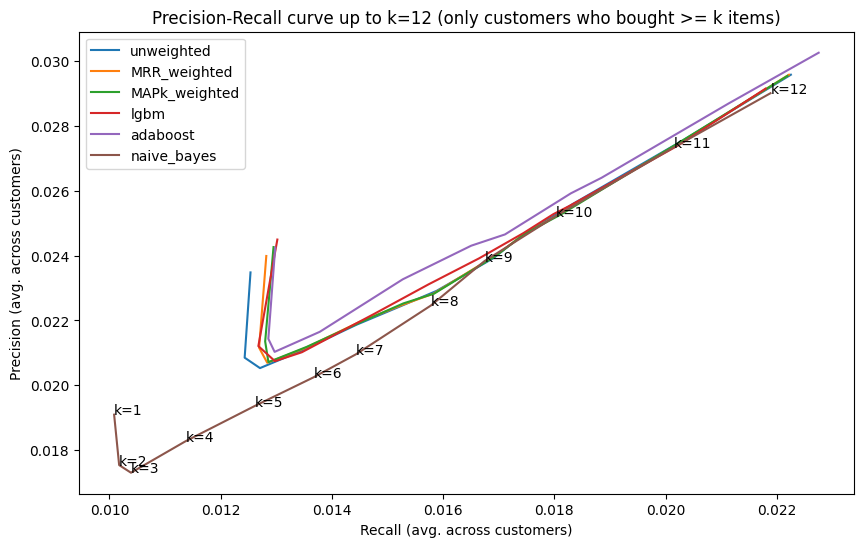

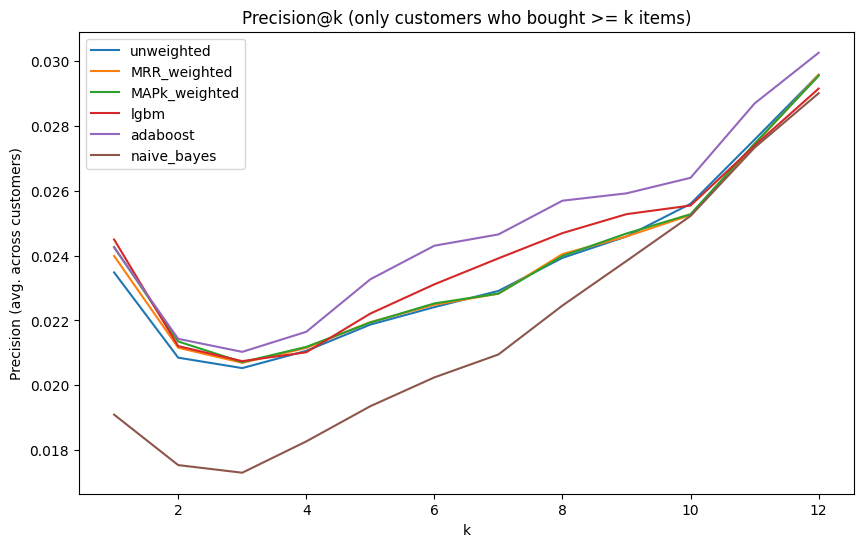

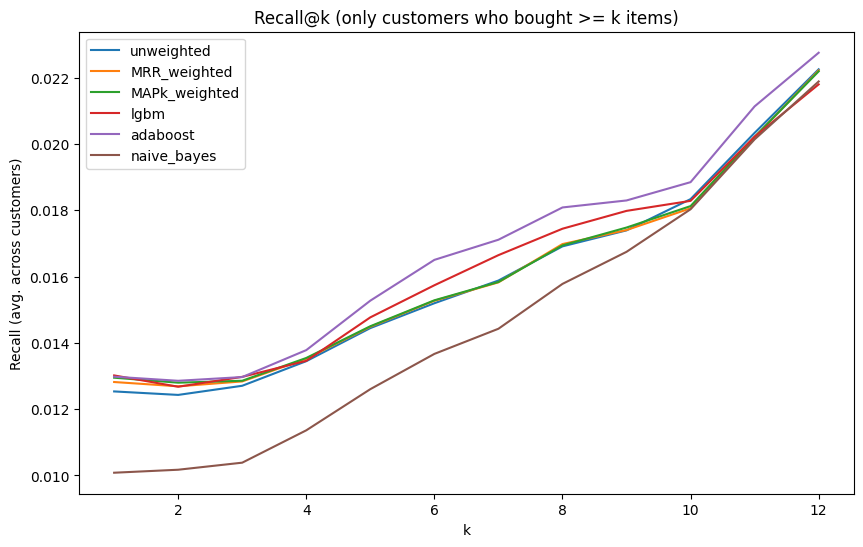

({'unweighted': [0.0011807752299596204,
   0.001080737328532486,
   0.0010724767610800936,
   0.0010894686268507307,
   0.0010938121061045596,
   0.0011012393280757245,
   0.0011054139061612094,
   0.001114755574139353,
   0.0011213822660098777,
   0.0011307518525647481,
   0.0011379344178290979],
  'MRR_weighted': [0.0012062858059155382,
   0.001099870260499424,
   0.001090516382648921,
   0.0011062782742216845,
   0.0011101813923429394,
   0.0011170951633567704,
   0.0011198935173519346,
   0.0011294393753021063,
   0.0011356653996028297,
   0.0011408457562253839,
   0.001150056083601461],
  'MAPk_weighted': [0.0012201344042916077,
   0.0011113500196795873,
   0.0010977038861920564,
   0.001112721719299439,
   0.0011170542654492855,
   0.0011230403423438302,
   0.0011257887825460657,
   0.0011351976358117116,
   0.0011416805253882877,
   0.0011459546588109255,
   0.001155374424759909],
  'lgbm': [0.001231796381871456,
   0.0011077056516858846,
   0.0011019758953402304,
   0.001117879

In [21]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)

### Retraining stacker without Naive Bayes ranker

In [22]:
del stacker.rankers[1]
for key, weights in stacker.ranker_weights.items():
    del weights[1]

In [23]:
pred_cols = ['unweighted', 'MRR_weighted', 'MAPk_weighted', 'lgbm', 'adaboost']

In [24]:
stacker.ranker_weights

{'MRR': [0.8944874811274849, 0.8405277140770797],
 'MAPk': [0.8650640535513492, 0.8024216439666433],
 'Pk': [(0.0, 0.0), (0.0, 0.0)]}

Evaluation for unweighted
####################

MAP@12 (all customers):             0.0011379344178290979
MAP@12 (only purchasing customers): 0.022631672019209747

MRR (all customers):                0.0021488717699303856
MRR (only purchasing customers):    0.04273757814723835



Evaluation for MRR_weighted
####################

MAP@12 (all customers):             0.001150056083601461
MAP@12 (only purchasing customers): 0.022872752313283267

MRR (all customers):                0.002168289993331177
MRR (only purchasing customers):    0.043123775151491774



Evaluation for MAPk_weighted
####################

MAP@12 (all customers):             0.001155374424759909
MAP@12 (only purchasing customers): 0.0229785255027557

MRR (all customers):                0.002178514496496539
MRR (only purchasing customers):    0.043327123954878255



Evaluation for lgbm
####################

MAP@12 (all customers):             0.001157985612232424
MAP@12 (only purchasing customers): 0.02303045779123624



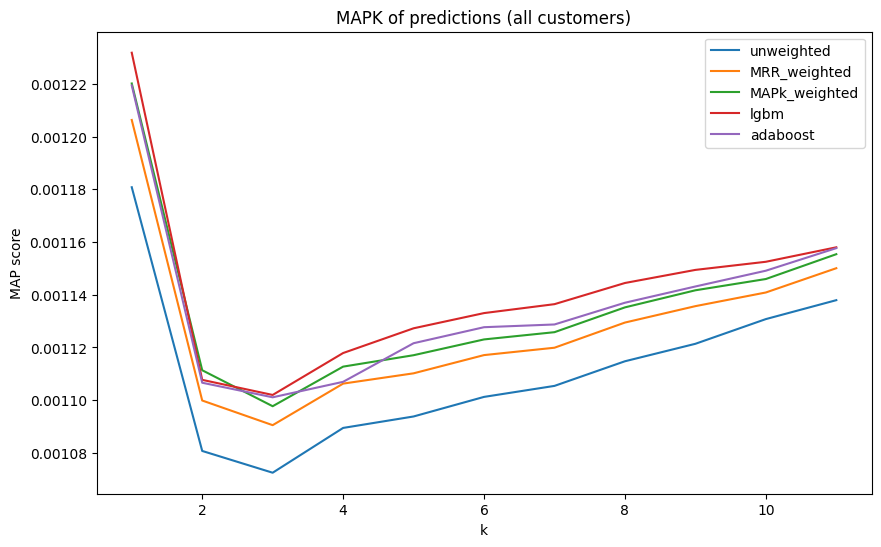

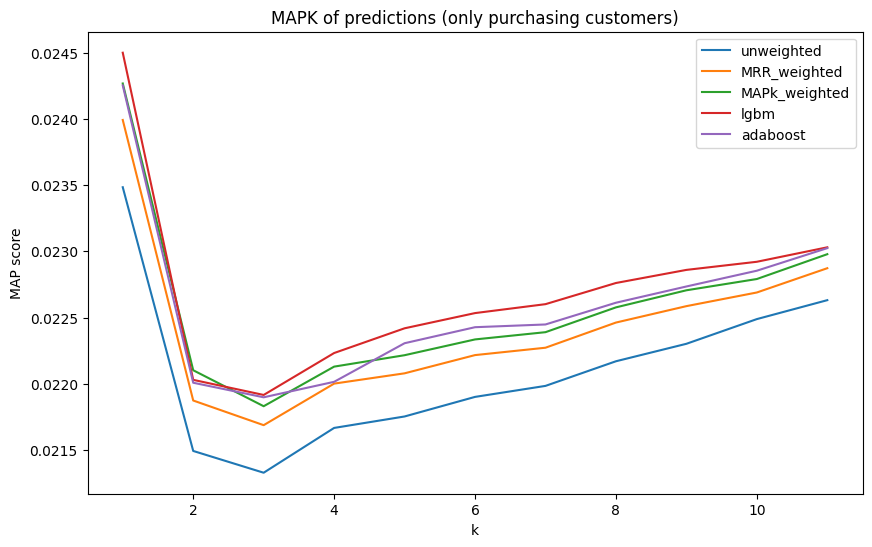

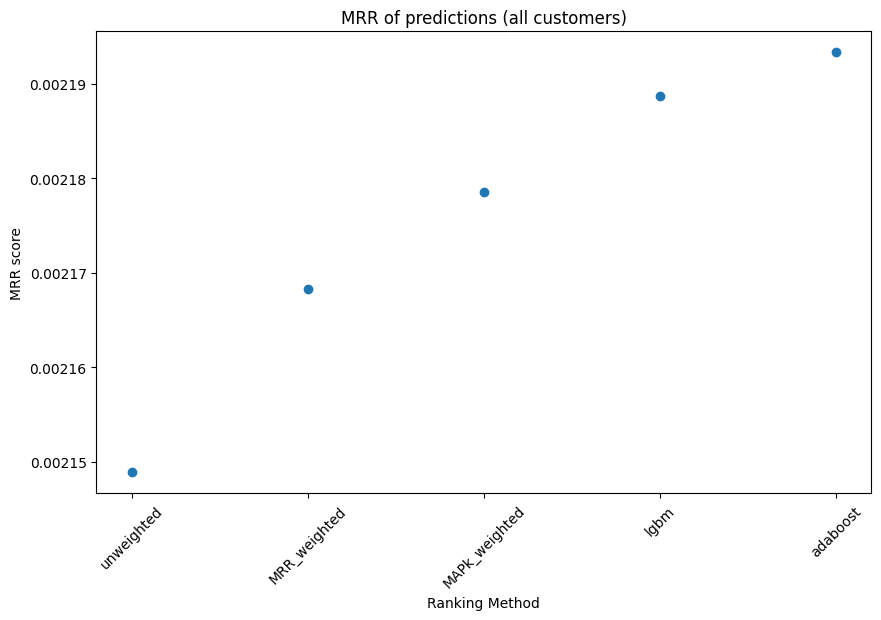

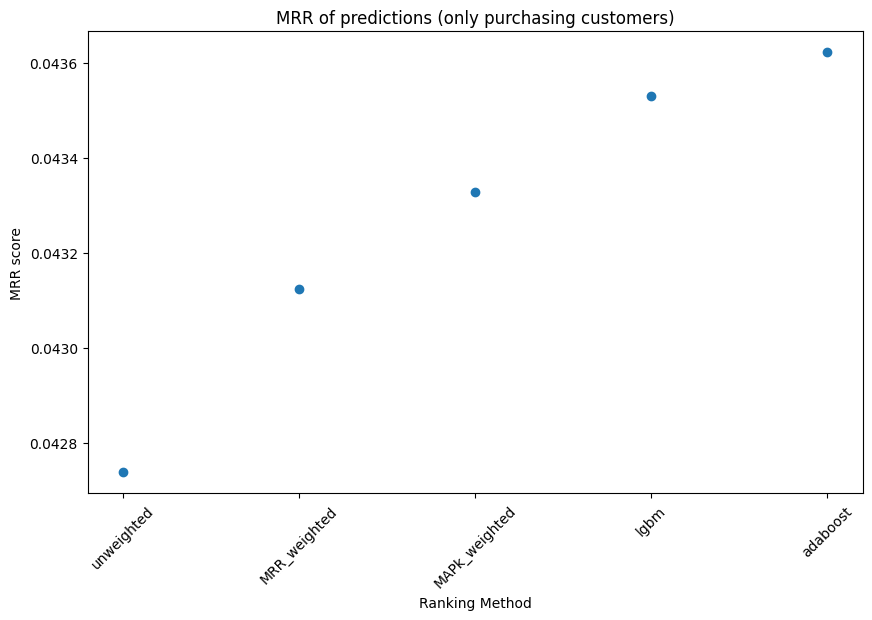

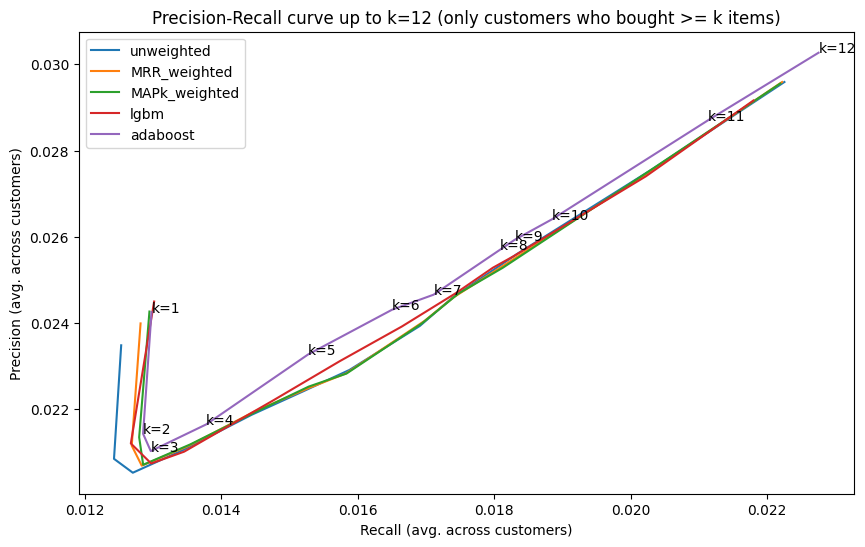

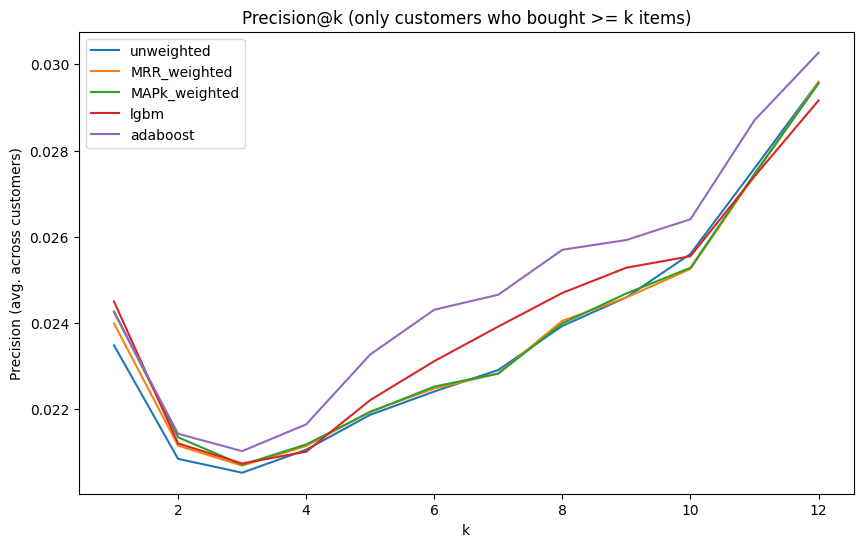

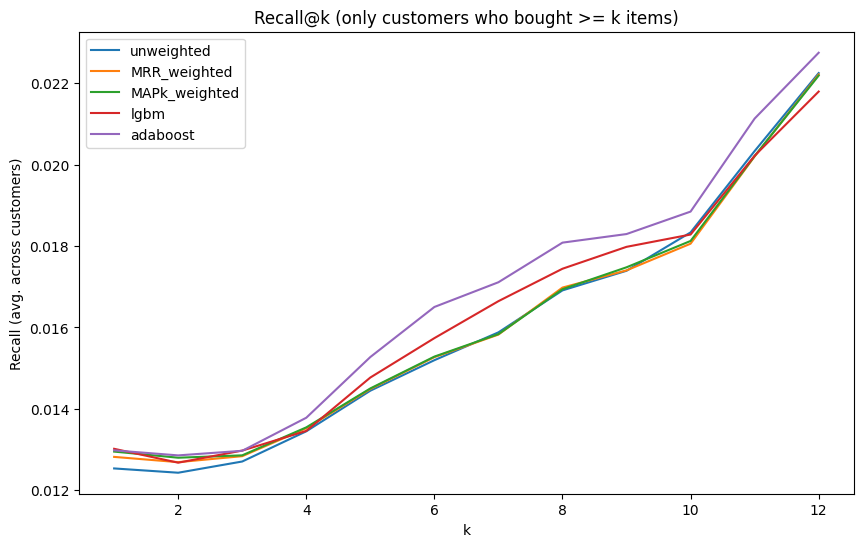

({'unweighted': [0.0011807752299596204,
   0.001080737328532486,
   0.0010724767610800936,
   0.0010894686268507307,
   0.0010938121061045596,
   0.0011012393280757245,
   0.0011054139061612094,
   0.001114755574139353,
   0.0011213822660098777,
   0.0011307518525647481,
   0.0011379344178290979],
  'MRR_weighted': [0.0012062858059155382,
   0.001099870260499424,
   0.001090516382648921,
   0.0011062782742216845,
   0.0011101813923429394,
   0.0011170951633567704,
   0.0011198935173519346,
   0.0011294393753021063,
   0.0011356653996028297,
   0.0011408457562253839,
   0.001150056083601461],
  'MAPk_weighted': [0.0012201344042916077,
   0.0011113500196795873,
   0.0010977038861920564,
   0.001112721719299439,
   0.0011170542654492855,
   0.0011230403423438302,
   0.0011257887825460657,
   0.0011351976358117116,
   0.0011416805253882877,
   0.0011459546588109255,
   0.001155374424759909],
  'lgbm': [0.001231796381871456,
   0.0011077056516858846,
   0.0011019758953402304,
   0.001117879

In [25]:
get_evaluation_plots(test, pred_cols, test_week_transactions, bestsellers_previous_week)